**Source of the data:** 
- https://www.kaggle.com/datasets/colearninglounge/gemstone-price-prediction

**Sources of the images:**
- Cut Chart     : https://blog.javda.com/which-diamond-cut-has-the-most-facets/
- Clarity Chart : https://www.u7jewelry.com/blogs/jewelry-guide/czcubic-zirconia-vs-diamond
- Color Chart   : https://beyond4cs.com/color/choosing-a-diamond-color/
- Depth & Table Chart : https://www.jewlr.com/info/diamond

In [67]:
# Importing initial libraries
import pandas as pd
import numpy as np
import seaborn as sns
from IPython.display import Image
import matplotlib.pyplot as plt

In [68]:
# Reading the data
gem_data = pd.read_csv("./cubic_zirconia.csv")

# Exploratory Data Analysis

In [69]:
gem_data.head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,x,y,z,price
0,1,0.30,Ideal,E,SI1,62.1,58.0,4.27,4.29,2.66,499
1,2,0.33,Premium,G,IF,60.8,58.0,4.42,4.46,2.70,984
2,3,0.90,Very Good,E,VVS2,62.2,60.0,6.04,6.12,3.78,6289
3,4,0.42,Ideal,F,VS1,61.6,56.0,4.82,4.80,2.96,1082
4,5,0.31,Ideal,F,VVS1,60.4,59.0,4.35,4.43,2.65,779


We can see that we have 11 columns. The first column serves as an index column, which is redundant and will be dropped.

In [70]:
gem_data.describe()

,Unnamed: 0,carat,depth,table,x,y,z,price
count,26967.000000,26967.000000,26270.000000,26967.000000,26967.000000,26967.000000,26967.000000,26967.000000
mean,13484.000000,0.798375,61.745147,57.456080,5.729854,5.733569,3.538057,3939.518115
std,7784.846691,0.477745,1.412860,2.232068,1.128516,1.166058,0.720624,4024.864666
min,1.000000,0.200000,50.800000,49.000000,0.000000,0.000000,0.000000,326.000000
25%,6742.500000,0.400000,61.000000,56.000000,4.710000,4.710000,2.900000,945.000000
50%,13484.000000,0.700000,61.800000,57.000000,5.690000,5.710000,3.520000,2375.000000
75%,20225.500000,1.050000,62.500000,59.000000,6.550000,6.540000,4.040000,5360.000000
max,26967.000000,4.500000,73.600000,79.000000,10.230000,58.900000,31.800000,18818.000000


- We can see that x, y and z variables have minimum values of 0, which is impossible for any 3D object, therefore further investigation will be made.

- It's also noticable that Y and Z variables have drastically changed their distributions after third quadrants, which could mean erroneous inputs.

- And finally, the range and standard deviation of the target variable, which is price, are quite extensive. This means that predicting the values of this variable could be harder as a regression problem. If that is the case, our approach can be changed and discretization can be applied to the target variable. As a result, the problem can become a classification problem.

In [71]:
gem_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26967 entries, 0 to 26966
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  26967 non-null  int64  
 1   carat       26967 non-null  float64
 2   cut         26967 non-null  object 
 3   color       26967 non-null  object 
 4   clarity     26967 non-null  object 
 5   depth       26270 non-null  float64
 6   table       26967 non-null  float64
 7   x           26967 non-null  float64
 8   y           26967 non-null  float64
 9   z           26967 non-null  float64
 10  price       26967 non-null  int64  
dtypes: float64(6), int64(2), object(3)
memory usage: 2.3+ MB


We can see that there are null values in the depth column, therefore imputation will be used.

## Understanding the columns for better possible approaches

Let's check out the provided dictionary.

In [156]:
df = pd.read_csv("./dictionary/dictionary.csv")
styles = [{'selector': 'th', 'props': [('text-align', 'left')]}]
styled_df = df.style.set_table_styles(styles).set_properties(**{'max-width': '100%', 'text-align': 'left'})

styled_df

,Variable Name,Description
0,Carat,Carat weight of the cubic zirconia.
1,Cut,"Describe the cut quality of the cubic zirconia. Quality is increasing order Fair, Good, Very Good, Premium, Ideal."
2,Color,Colour of the cubic zirconia.With D being the best and J the worst.
3,Clarity,"cubic zirconia Clarity refers to the absence of the Inclusions and Blemishes. (In order from Best to Worst, FL = flawless, I3= level 3 inclusions) FL, IF, VVS1, VVS2, VS1, VS2, SI1, SI2, I1, I2, I3"
4,Depth,"The Height of a cubic zirconia, measured from the Culet to the table, divided by its average Girdle Diameter."
5,Table,The Width of the cubic zirconia's Table expressed as a Percentage of its Average Diameter.
6,Price,the Price of the cubic zirconia.
7,X,Length of the cubic zirconia in mm.
8,Y,Width of the cubic zirconia in mm.
9,Z,Height of the cubic zirconia in mm.


And here are some explanatory images for columns:

##### Cut

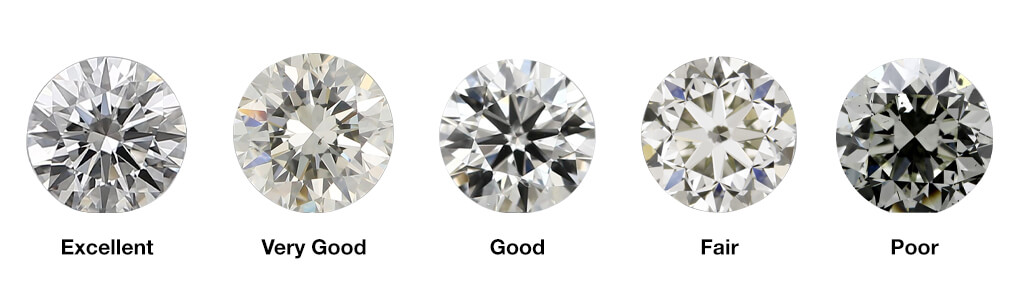

In [150]:
Image(filename='./dictionary/chart_cut.jpg', width=600)

################################ P.S. #######################################
# Following values in the dataset:                                          #
#           Fair,     Good,   Very Good,  Premium,    Ideal                 #
# are corresponding to the respective values below in the chart             #
#           Poor,     Fair,   Good,       Very Good,  Excellent             #
#############################################################################

##### Color

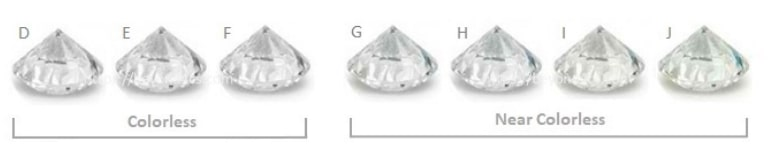

In [148]:
Image(filename='./dictionary/chart_color.jpg', width=600)

##### Clarity

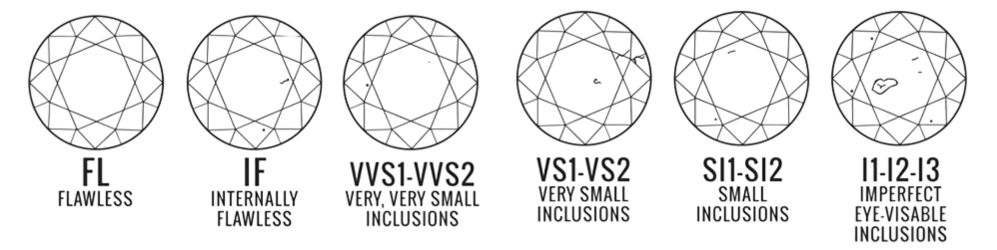

In [149]:
Image(filename='./dictionary/chart_clarity.jpg', width=600)

##### Depth & Table

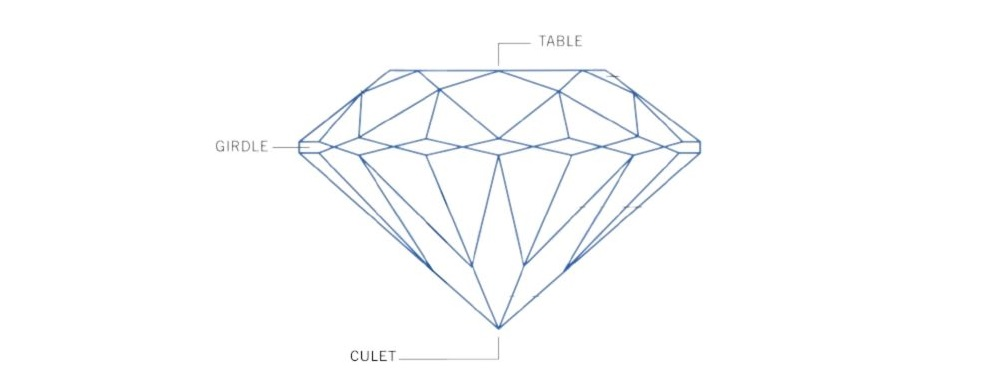

In [151]:
Image(filename='./dictionary/chart_size.jpg', width=600)

################################ P.S. #######################################
# Values of following columns in the dataset are calculated as:             #
# [Depth] = [ Height("Culet-Table Distance") / Girdle Diameter ] as percent #
# [Table] = [ Table Diameter / Girdle Diameter ] as percent                 #
#############################################################################

# Preprocessing

First, we start by removing the redundant index column.

In [75]:
gem_data = gem_data.drop("Unnamed: 0", axis=1)

gem_data.head()

,carat,cut,color,clarity,depth,table,x,y,z,price
0,0.30,Ideal,E,SI1,62.1,58.0,4.27,4.29,2.66,499
1,0.33,Premium,G,IF,60.8,58.0,4.42,4.46,2.70,984
2,0.90,Very Good,E,VVS2,62.2,60.0,6.04,6.12,3.78,6289
3,0.42,Ideal,F,VS1,61.6,56.0,4.82,4.80,2.96,1082
4,0.31,Ideal,F,VVS1,60.4,59.0,4.35,4.43,2.65,779


## 1) Investigating values in columns : "X", "Y" and "Z"

We should check the distributions of variables x, y and z.

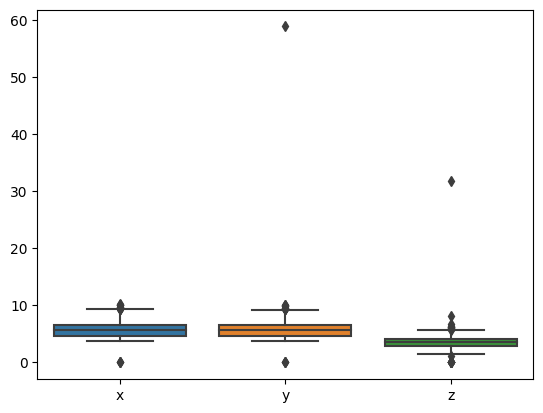

In [76]:
sns.boxplot(data=gem_data[["x", "y", "z"]])
plt.show()

We will save the x, y and z variables of the data for comparison in the next steps.

In [77]:
gem_data_original = gem_data[["x", "y", "z"]].copy()

Y and Z columns have extreme outliers. We should take a look at them.

### Investigating the outliers in columns "y" and "z"

#### Details of the possible outliers in column "y", which are higher than 10

In [78]:
gem_data[gem_data["y"] > 10]

,carat,cut,color,clarity,depth,table,x,y,z,price
12500,4.50,Fair,J,I1,65.8,58.0,10.23,10.16,6.72,18531
20505,4.01,Premium,I,I1,61.0,61.0,10.14,10.10,6.17,15223
25795,2.00,Premium,H,SI2,58.9,57.0,8.09,58.90,8.06,12210


In [79]:
gem_data["y"].mean()

5.733568806318835

Since the y value of the outlier (**58.9**) is very high and much different than both the mean (**5.73**) and the closest values (**10.16, 10.10**), we will drop the row.

In [80]:
gem_data = gem_data.drop(25795, axis=0)
gem_data[gem_data["y"] > 10]

,carat,cut,color,clarity,depth,table,x,y,z,price
12500,4.50,Fair,J,I1,65.8,58.0,10.23,10.16,6.72,18531
20505,4.01,Premium,I,I1,61.0,61.0,10.14,10.10,6.17,15223


#### Details of the possible outliers in column "z", which are higher than 6

In [81]:
gem_data[gem_data["z"] > 6]

,carat,cut,color,clarity,depth,table,x,y,z,price
344,0.51,Very Good,E,VS1,NaN,54.7,5.12,5.15,31.80,1970
3025,4.01,Premium,J,I1,62.5,62.0,10.02,9.94,6.24,15223
8156,4.00,Very Good,I,I1,63.3,58.0,10.01,9.94,6.31,15984
8573,3.50,Ideal,H,I1,62.8,57.0,9.65,9.59,6.03,12587
12500,4.50,Fair,J,I1,65.8,58.0,10.23,10.16,6.72,18531
12758,3.40,Fair,D,I1,66.8,52.0,9.42,9.34,6.27,15964
15080,3.51,Premium,J,VS2,62.5,59.0,9.66,9.63,6.03,18701
20505,4.01,Premium,I,I1,61.0,61.0,10.14,10.10,6.17,15223


In [82]:
gem_data["z"].mean()

3.537889564636951

Since the z value of the outlier (**31.80**) is very high and much different than both the mean (**3.53**) and the closest values (**6.72, 6.31, ...**), we will drop the row.

In [83]:
# we can drop the extreme outlier, which has the z value of 31.80
gem_data = gem_data.drop(344, axis=0)
gem_data[gem_data["z"] > 6]

,carat,cut,color,clarity,depth,table,x,y,z,price
3025,4.01,Premium,J,I1,62.5,62.0,10.02,9.94,6.24,15223
8156,4.00,Very Good,I,I1,63.3,58.0,10.01,9.94,6.31,15984
8573,3.50,Ideal,H,I1,62.8,57.0,9.65,9.59,6.03,12587
12500,4.50,Fair,J,I1,65.8,58.0,10.23,10.16,6.72,18531
12758,3.40,Fair,D,I1,66.8,52.0,9.42,9.34,6.27,15964
15080,3.51,Premium,J,VS2,62.5,59.0,9.66,9.63,6.03,18701
20505,4.01,Premium,I,I1,61.0,61.0,10.14,10.10,6.17,15223


We will save the x, y and z variables of the data for comparison in the next steps.

In [84]:
gem_data_cleaner = gem_data[["x", "y", "z"]].copy()

### Investigating the 0 values in columns "x", "y" and "z"

We can say that x y and z columns having 0 as value is problematic and probably accidentally inputted values, since the size of any dimension of a 3D object can't be 0.

#### Details of the possible outliers in column "x", which are less than 2

In [85]:
gem_data[gem_data["x"] < 2]

,carat,cut,color,clarity,depth,table,x,y,z,price
5821,0.71,Good,F,SI2,64.1,60.0,0.0,0.0,0.0,2130
6215,0.71,Good,F,SI2,64.1,60.0,0.0,0.0,0.0,2130
17506,1.14,Fair,G,VS1,57.5,67.0,0.0,0.0,0.0,6381


#### Details of the possible outliers in column "y", which are less than 2

In [86]:
gem_data[gem_data["y"] < 2]

,carat,cut,color,clarity,depth,table,x,y,z,price
5821,0.71,Good,F,SI2,64.1,60.0,0.0,0.0,0.0,2130
6215,0.71,Good,F,SI2,64.1,60.0,0.0,0.0,0.0,2130
17506,1.14,Fair,G,VS1,57.5,67.0,0.0,0.0,0.0,6381


#### Details of the possible outliers in column "z", which are less than 2

In [87]:
gem_data[gem_data["z"] < 2]

,carat,cut,color,clarity,depth,table,x,y,z,price
4828,1.53,Ideal,I,SI1,61.9,54.0,7.43,7.50,1.53,8971
5821,0.71,Good,F,SI2,64.1,60.0,0.00,0.00,0.00,2130
6034,2.02,Premium,H,VS2,62.7,53.0,8.02,7.95,0.00,18207
6215,0.71,Good,F,SI2,64.1,60.0,0.00,0.00,0.00,2130
10827,2.20,Premium,H,SI1,61.2,59.0,8.42,8.37,0.00,17265
12498,2.18,Premium,H,SI2,59.4,61.0,8.49,8.45,0.00,12631
12689,1.10,Premium,G,SI2,63.0,59.0,6.50,6.47,0.00,3696
17506,1.14,Fair,G,VS1,57.5,67.0,0.00,0.00,0.00,6381
18194,1.01,Premium,H,I1,58.1,59.0,6.66,6.60,0.00,3167
21604,1.07,Ideal,F,SI1,60.6,57.0,6.62,6.67,1.07,5909


#### Solution

We will drop the rows with x, y or z equal to 0, since it is not possible to have a gemstone with 0, 1 or 2 dimensions and all dimensions must have a value higher than 0.

In [88]:
gem_data = gem_data.drop(gem_data[(gem_data["x"] == 0) | (gem_data["y"] == 0) | (gem_data["z"] == 0)].index, axis=0)
gem_data[gem_data["z"] < 2]

,carat,cut,color,clarity,depth,table,x,y,z,price
4828,1.53,Ideal,I,SI1,61.9,54.0,7.43,7.50,1.53,8971
21604,1.07,Ideal,F,SI1,60.6,57.0,6.62,6.67,1.07,5909


### Comparison

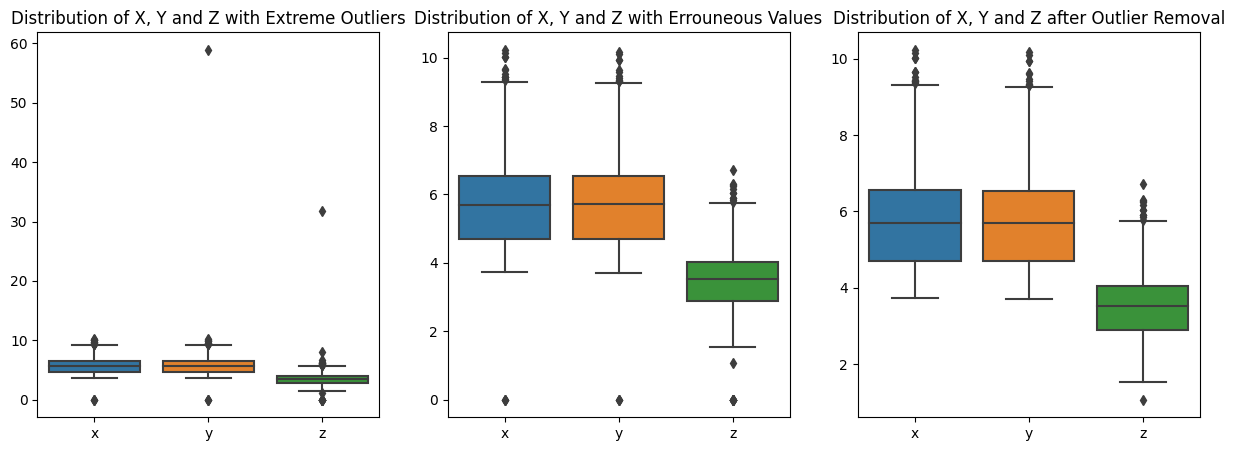

In [89]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.boxplot(data=gem_data_original[["x", "y", "z"]], ax=axes[0])
axes[0].set_title("Distribution of X, Y and Z with Extreme Outliers")
sns.boxplot(data=gem_data_cleaner[["x", "y", "z"]], ax=axes[1])
axes[1].set_title("Distribution of X, Y and Z with Errouneous Values")
sns.boxplot(data=gem_data[["x", "y", "z"]], ax=axes[2])
axes[2].set_title("Distribution of X, Y and Z after Outlier Removal")
plt.show()

We can see that when the outliers and erroneous values are dropped, the clean version looks much better and correct in comparison.

## 2) Investigating columns : "Cut", "Color" and "Clarity"

For better visualizations, it might be better to get the unique values in these 3 columns ordered from worst to best for custom color palettes.

Also, the obtained dictionaries will be used in Label Encoding. 

In [90]:
cut_sort = {"Fair": 1, "Good": 2, "Very Good": 3, "Premium": 4, "Ideal": 5}
sorted_cut_unique = sorted(gem_data["cut"].unique(), key=cut_sort.get)
cut_unique_dict = {k: v+1 for v, k in enumerate(sorted_cut_unique)}
cut_unique_list = sorted(gem_data["cut"].unique(), key=cut_sort.get)

color_sort = {"J": 1, "I": 2, "H": 3, "G": 4, "F": 5, "E": 6, "D": 7}
sorted_color_unique = sorted(gem_data["color"].unique(), key=color_sort.get)
color_unique_dict = {k: v+1 for v, k in enumerate(sorted_color_unique)}
color_unique_list = sorted(gem_data["color"].unique(), key=color_sort.get)

clarity_sort = {"I3": 1, "I2": 2, "I1": 3, "SI2": 4, "SI1": 5, "VS2": 6, "VS1": 7, "VVS2": 8, "VVS1": 9, "IF": 10, "FL": 11}
sorted_clarity_unique = sorted(gem_data["clarity"].unique(), key=clarity_sort.get)
clarity_unique_dict = {k: v+1 for v, k in enumerate(sorted_clarity_unique)}
clarity_unique_list = sorted(gem_data["clarity"].unique(), key=clarity_sort.get)

print(cut_unique_dict)
print(color_unique_dict)
print(clarity_unique_dict)

{'Fair': 1, 'Good': 2, 'Very Good': 3, 'Premium': 4, 'Ideal': 5}
{'J': 1, 'I': 2, 'H': 3, 'G': 4, 'F': 5, 'E': 6, 'D': 7}
{'I1': 1, 'SI2': 2, 'SI1': 3, 'VS2': 4, 'VS1': 5, 'VVS2': 6, 'VVS1': 7, 'IF': 8}


Now, we will create custom color palettes for these 3 columns, ordered as red being the worst, purple being the best.

In [91]:
cut_map = {"Fair": "#ffb3ba", "Good": "#ffffba", "Very Good": "#baffc9", "Premium": "#bae1ff", "Ideal": "#EA8FEA"}
cut_map_sorted = {k: v for k, v in sorted(cut_map.items(), key=lambda item: gem_data["cut"].value_counts()[item[0]], reverse=True)}

color_map = {"D": "#EA8FEA", "E": "#7286D3", "F": "#bae1ff", "G": "#baffc9", "H": "#ffffba", "I": "#ffdfba", "J": "#ffb3ba"}
color_map_sorted = {k: v for k, v in sorted(color_map.items(), key=lambda item: gem_data["color"].value_counts()[item[0]], reverse=True)}

clarity_map = {"IF": "#EA8FEA", "VVS1": "#7286D3", "VVS2": "#bae1ff", "VS1": "#baffc9", "VS2": "#ffffba", "SI1": "#ffdfba", "SI2": "#ffc5ba", "I1": "#ffa0ba"}
clarity_map_sorted = {k: v for k, v in sorted(clarity_map.items(), key=lambda item: gem_data["clarity"].value_counts()[item[0]], reverse=True)}

### Investigating the column "cut"

We should check the distribution of cut variable according to price.

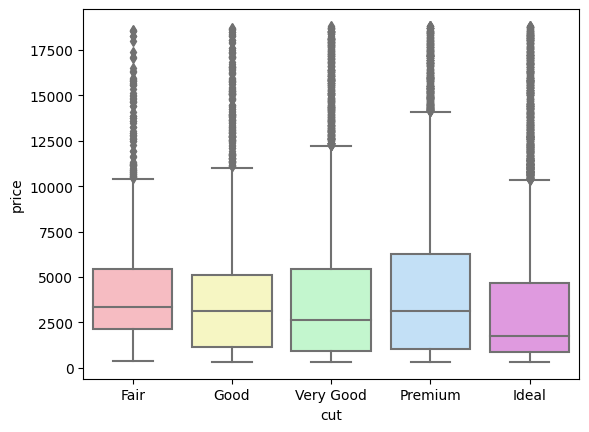

In [92]:
sns.boxplot(x="cut", y="price", data=gem_data, order=cut_unique_list, palette = cut_map_sorted)
plt.show()

We can't conclude a direct correlation between cut and price for now. The reason behind this could be the case that size ("x", "y" and "z") or "carat" of the "cubic zirconia" being more effective than "cut".

### Investigating the column "color"

We should check the distribution of color variable according to price.

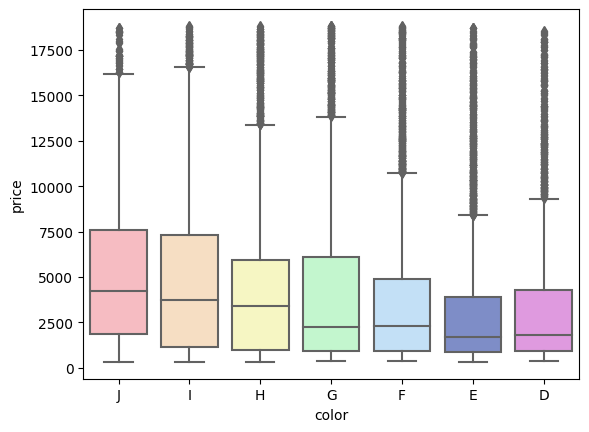

In [93]:
sns.boxplot(x="color", y="price", data=gem_data, order=color_unique_list, palette = color_map_sorted)
plt.show()

There seems to be a low negative correlation between color and price, which is unexpected. We might need to check other factors, such as "carat".

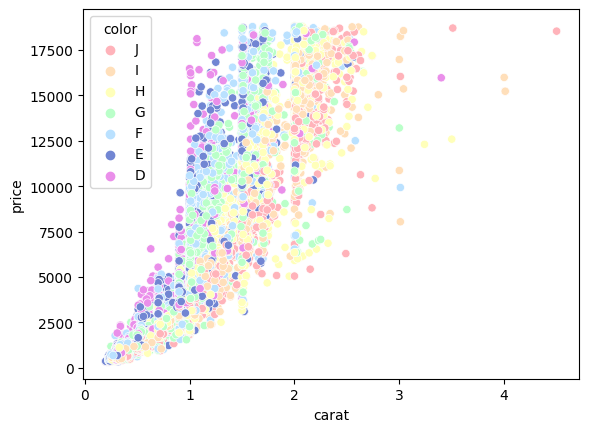

In [94]:
sns.scatterplot(x="carat", y="price", data=gem_data, hue="color", palette=color_map_sorted, hue_order = color_unique_list, legend="full")
plt.show()

Since the values are too dense in this plot, dividing it into two could be better.

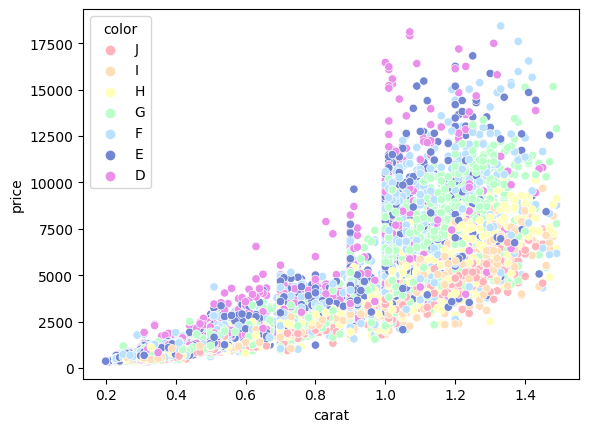

In [95]:
sns.scatterplot(x="carat", y="price", data=gem_data[gem_data["carat"] < 1.5], hue="color", palette=color_map_sorted, hue_order = color_unique_list, legend="full")
plt.show()

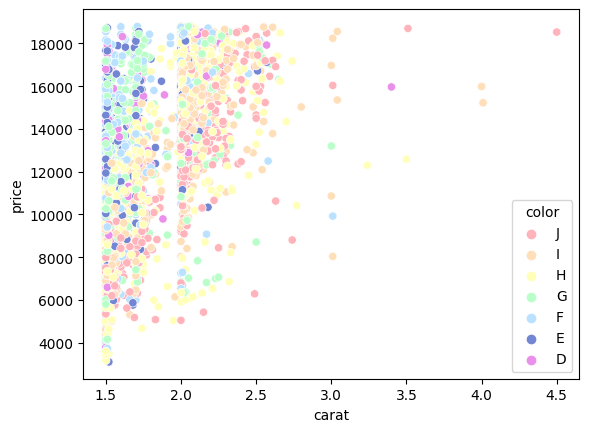

In [96]:
sns.scatterplot(x="carat", y="price", data=gem_data[gem_data["carat"] >= 1.5], hue="color", palette=color_map, hue_order = color_unique_list, legend="full")
plt.show()

- Judging by the plots above, it's easy to see that when carat values increase, the chance of having a worse color is higher. 
- Also when the prices of different colored cubic zirconia with same carat value are compared, we can see that better color has higher price.
- This indicates that color is a varient that affects the price. But carat has much higher effect.

### Investigating the column "clarity"

We should check the distribution of clarity variable according to price.

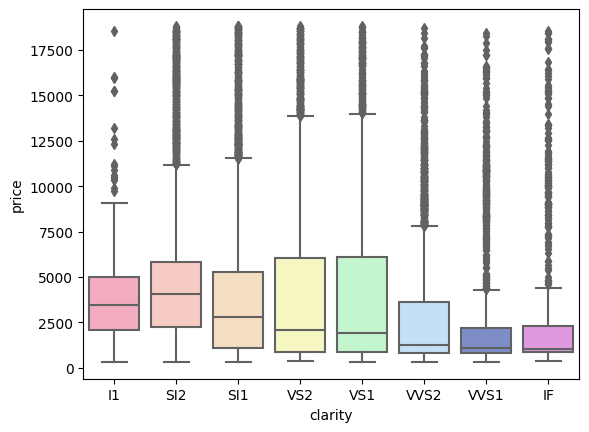

In [97]:
sns.boxplot(x="clarity", y="price", data=gem_data, order=clarity_unique_list, palette = clarity_map_sorted)
plt.show()

We can't conclude a direct correlation between clarity and price for now. The reason behind this could be the case that size ("x", "y" and "z") or "carat" of the "cubic zirconia" being more effective than "clarity".

### Label Encoding

For further steps, it is better to convert these categorical variables to ordinal variables using the dictionaries we created earlier

In [98]:
gem_data["cut"] = gem_data["cut"].map(cut_unique_dict)
gem_data["color"] = gem_data["color"].map(color_unique_dict)
gem_data["clarity"] = gem_data["clarity"].map(clarity_unique_dict)

gem_data.head()

,carat,cut,color,clarity,depth,table,x,y,z,price
0,0.30,5,6,3,62.1,58.0,4.27,4.29,2.66,499
1,0.33,4,4,8,60.8,58.0,4.42,4.46,2.70,984
2,0.90,3,6,6,62.2,60.0,6.04,6.12,3.78,6289
3,0.42,5,5,5,61.6,56.0,4.82,4.80,2.96,1082
4,0.31,5,5,7,60.4,59.0,4.35,4.43,2.65,779


## 3) Imputing the missing values

We should check which columns have missing values.

In [99]:
gem_data.isnull().sum()

carat        0
cut          0
color        0
clarity      0
depth      696
table        0
x            0
y            0
z            0
price        0
dtype: int64

We can try to see whether the missing values have a pattern in terms of position etc. by visualizing the data with missingness map.

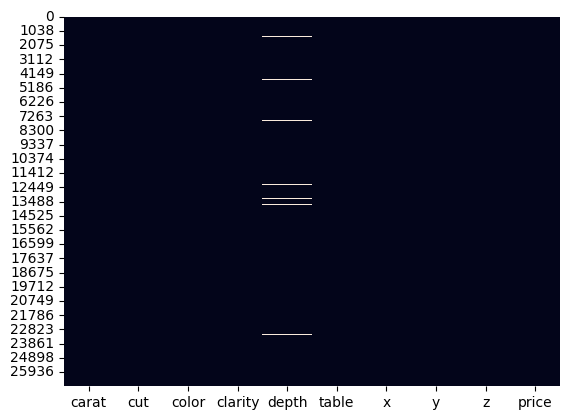

In [100]:
sns.heatmap(gem_data.isnull(), cbar=False)
plt.show()

It seems there is no pattern and the missing values are random. 

### Imputing column "Depth"

We have 3 options for dealing with missing values
1. Impute the missing values with the mean of the column
2. Impute the missing values with the median of the column
3. Impute the missing values with machine learning algorithms, such as KNN

#### Option 1: Imputing with the mean

In [101]:
print(gem_data["depth"].mean())
# gem_data["depth"] = gem_data["depth"].fillna(gem_data["depth"].mean())

61.74545316070068


#### Option 2: Imputing with the median

In [102]:
print(gem_data["depth"].median())
# gem_data["depth"] = gem_data["depth"].fillna(gem_data["depth"].median())

61.8


#### Option 3: Imputing using machine learning algorithms, such as KNN

Since there are 696 missing values in column "depth", it might be better to impute the missing values using a machine learning algorithm.

We will use KNN since it is a fast and common imputation algorithm.

In [103]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5)
gem_data_imputed = imputer.fit_transform(gem_data)
gem_data_imputed = pd.DataFrame(gem_data_imputed, columns=gem_data.columns)

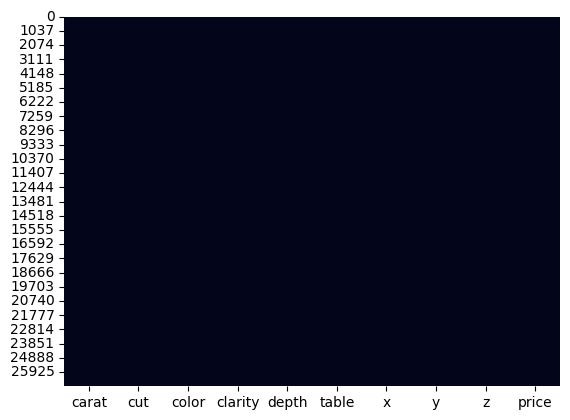

In [104]:
# missingness map for imputed dataset
sns.heatmap(gem_data_imputed.isnull(), cbar=False)
plt.show()

We can see that all missing values are imputed in column "depth" and there are no missing values remaining.

# Checking Linear Correlation

We should check for correlation between variables, which could be crucial for deciding whether we need to engineer a new feature or not.

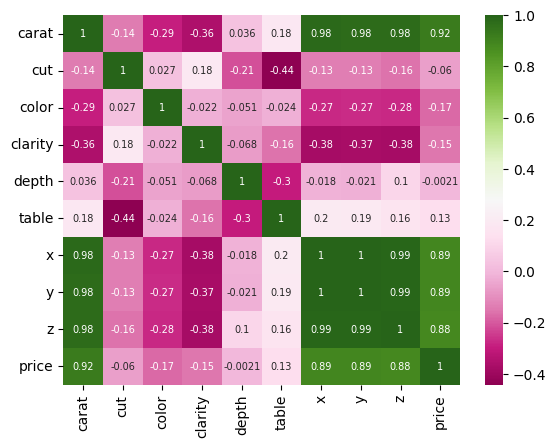

In [105]:
sns.heatmap(gem_data_imputed.corr(), cmap="PiYG", annot=True, annot_kws={"size": 7})
plt.show()

- At first glance, we can see that "price" has high positive correlations with columns "carat", "x", "y" and "z".

- Also, the correlations between "price" and columns "cut", "color", "clarity", "depth" and "table" is so low that it's safe to say that there is no correlation between these columns.

- And finally, the correlations between columns "x", "y", "z" and "carat" is almost 1, meaning we might not need all these variables. Engineering a new variable such as "volume" or "density" could be beneficial.

In [106]:
gem_data_volume = gem_data_imputed.copy()
gem_data_volume["volume"] = gem_data_volume["x"]*gem_data_volume["y"]*gem_data_volume["z"]
gem_data_volume.drop(["x", "y", "z"], axis=1, inplace=True)

gem_data_density = gem_data_volume.copy()
gem_data_density["density"] = gem_data_density["carat"]/gem_data_density["volume"]
gem_data_density.drop(["carat", "volume"], axis=1, inplace=True)

Now, let's check the correlation matrices and compare.

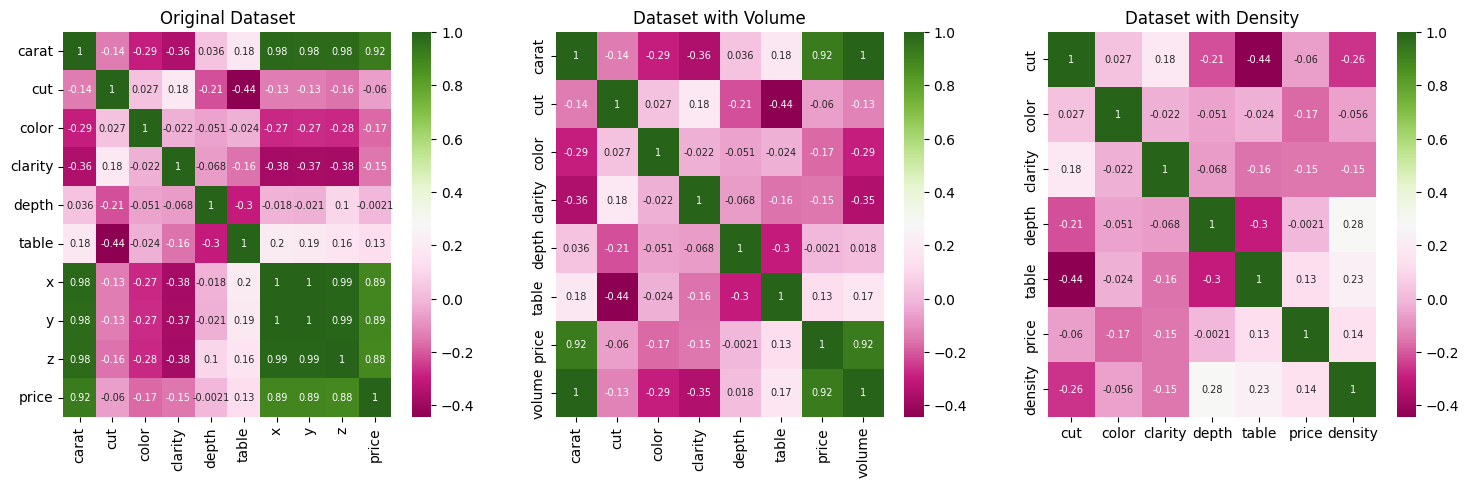

In [107]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.heatmap(gem_data_imputed.corr(), cmap="PiYG", annot=True, annot_kws={"size": 7}, ax=axes[0])
axes[0].set_title("Original Dataset")
sns.heatmap(gem_data_volume.corr(), cmap="PiYG", annot=True, annot_kws={"size": 7}, ax=axes[1])
axes[1].set_title("Dataset with Volume")
sns.heatmap(gem_data_density.corr(), cmap="PiYG", annot=True, annot_kws={"size": 7}, ax=axes[2])
axes[2].set_title("Dataset with Density")
plt.show()

- We can say that engineering the "volume" variable could be beneficial, since the correlation between "volume" and "price" is higher than any of the dropped "x", "y" or "z" columns. Also reduction of multicollinearity and dimensionality is a good side effect. But "carat" and "volume" having a corelation value of 1 looks a little bit concerning.
- We can further reduce multicollinearity and dimensionality by engineering a variable that is even more advanced named "density", which combines "volume" and "carat". But the correlation matrix of the resulting dataset is not looking good since the target variable has almost no correlation with any variable.

# Regression Models

**Regression Algorithms That Will Be Used:**

- *Linear Regression*
- *K-Nearest Neighbors*
- *Decision Tree*
- *Random Forest*
- *Support Vector Machine*
- *Lasso Regression*
- *Ridge Regression*
- *Elastic Net Regression*

First, we should import the respective algorithms and create the models.

In [108]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet

In [109]:
# Linear regression model
linear_model = LinearRegression()
# K-nearest neighbors regression model
knn_model = KNeighborsRegressor()
# Decision tree regression model
decision_tree_model = DecisionTreeRegressor()
# Random forest regression model
random_forest_model = RandomForestRegressor()
# Support vector regression model
svr_model = SVR()
# Lasso regression model
lasso_model = Lasso(alpha=0.1, tol=0.01)
# Ridge regression model
ridge_model = Ridge()
# Elastic net regression model
elastic_net_model = ElasticNet(alpha=0.1, l1_ratio=0.5)

Secondly, we defined a function that:
- Takes model name, model, splitted test/train data of independant/dependant variables and dataframe to hold the results as parameters,
- Fits the model to the training data,
- Predicts the test data,
- Calculates following metrics:
    - Mean Squared Error
    - Root Mean Squared Error
    - Mean Absolute Error
    - Mean Absolute Percentage Error
    - Coefficient of Determination
    - Adjusted Coefficient of Determination
    - Explained Variance Score
- Adds these metrics with the name of the model to the dataframe given as parameter,
- And finally returns the predicted data for comparison

to make the process easier.

In [110]:
def regression(modelName, model, X_train, X_test, y_train, y_test, results):
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    # mean squared error
    mse = np.mean((y_pred - y_test) ** 2)
    # root mean squared error
    rmse = np.sqrt(mse)
    # mean absolute error
    mae = np.mean(np.abs(y_pred - y_test))
    # mean absolute percentage error
    mape = np.mean(np.abs((y_pred - y_test) / y_test)) * 100
    # coefficient of determination
    r2 = 1 - (np.sum((y_test - y_pred) ** 2) / np.sum((y_test - np.mean(y_test)) ** 2))
    # adjusted coefficient of determination
    adj_r2 = 1 - ((1 - r2) * (len(y_test) - 1) / (len(y_test) - X_test.shape[1] - 1))
    # explained variance score
    evs = 1 - (np.var(y_test - y_pred) / np.var(y_test))

    results.loc[len(results)] = [modelName, mse, rmse, mae, mape, r2, adj_r2, evs]

    return y_pred

### Original Data Results

After that, we separated dependent/independent variables and splitted them as test/train data.

In [111]:
# Independent variables
X = gem_data_imputed.drop("price", axis=1)

# Dependent variable
y = gem_data_imputed["price"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Then, we defined a dataframe that will hold the results of the metrics for each model.

In [112]:
results = pd.DataFrame(columns=["Model", 
                                "Mean Squared Error",
                                "Root Mean Squared Error",
                                "Mean Absolute Error",
                                "Mean Absolute Percentage Error",
                                "Coefficient of Determination",
                                "Adjusted Coefficient of Determination",
                                "Explained Variance Score"],
                                index=None)

Finally, we called the function we defined above for every model.

In [113]:
lr_preds = regression("Linear Regression", linear_model, X_train, X_test, y_train, y_test, results)
knn_preds = regression("K-Nearest Neighbors Regression", knn_model, X_train, X_test, y_train, y_test, results)
dt_preds = regression("Decision Tree Regression", decision_tree_model, X_train, X_test, y_train, y_test, results)
rf_preds = regression("Random Forest Regression", random_forest_model, X_train, X_test, y_train, y_test, results)
svr_preds = regression("Support Vector Regression", svr_model, X_train, X_test, y_train, y_test, results)
lasso_preds = regression("Lasso Regression", lasso_model, X_train, X_test, y_train, y_test, results)
ridge_preds = regression("Ridge Regression", ridge_model, X_train, X_test, y_train, y_test, results)
elastic_net_preds = regression("Elastic Net Regression", elastic_net_model, X_train, X_test, y_train, y_test, results)

c:\Users\mehme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.107e+10, tolerance: 3.041e+09
  model = cd_fast.enet_coordinate_descent(


Now, we can check the results.

In [114]:
results

,Model,Mean Squared Error,Root Mean Squared Error,Mean Absolute Error,Mean Absolute Percentage Error,Coefficient of Determination,Adjusted Coefficient of Determination,Explained Variance Score
0,Linear Regression,1.417162e+06,1190.446081,809.047260,45.697245,0.913331,0.913234,0.913332
1,K-Nearest Neighbors Regression,8.902628e+05,943.537413,513.421640,14.954707,0.945554,0.945493,0.945707
2,Decision Tree Regression,5.979068e+05,773.244314,387.644924,9.364087,0.963434,0.963393,0.963434
3,Random Forest Regression,3.076192e+05,554.634331,281.682789,6.986513,0.981187,0.981166,0.981187
4,Support Vector Regression,1.852070e+07,4303.568830,2801.975869,109.334764,-0.132672,-0.133934,0.010379
5,Lasso Regression,1.417080e+06,1190.411787,808.900977,45.707605,0.913336,0.913239,0.913337
6,Ridge Regression,1.416376e+06,1190.115933,809.910743,45.787856,0.913379,0.913282,0.913380
7,Elastic Net Regression,2.198139e+06,1482.612099,1115.968376,65.647717,0.865568,0.865418,0.865572


We will compare the models by using the following two metrics:
- **Mean Absolute Percentage Error :**
    - Lower values indicate better performance.
    - On average, the predicted values deviate by **_[MAPE value]_** percent from the actual values.
- **Coefficient of Determination (R-squared) Score :**
    - Higher values indicate better performance.
    - **_[R2 value]_** of the variance in the target variable can be explained by the independent variables. Ranges from 0 to 1. Closer to 1 means a better fit, while closer to 0 means the model does not explain much of the variability.

and visualizing the actual values vs. the predicted values for each algorithm in scatter plots.

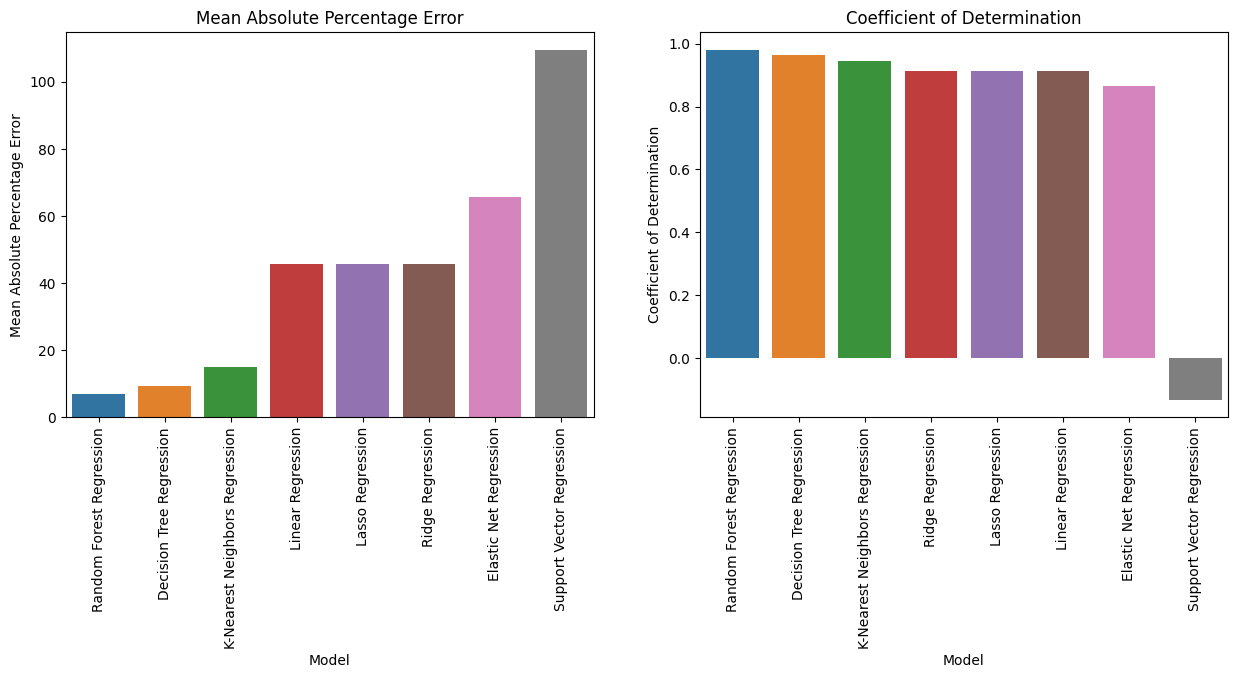

In [115]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
barplot_result = sns.barplot(x="Model", y="Mean Absolute Percentage Error", data=results, order=results.sort_values('Mean Absolute Percentage Error').Model, ax=axes[0])
barplot_result.set_xticklabels(barplot_result.get_xticklabels(), rotation=90,)
axes[0].set_title("Mean Absolute Percentage Error")
barplot_result = sns.barplot(x="Model", y="Coefficient of Determination", data=results, order=results.sort_values('Coefficient of Determination', ascending=False).Model, ax=axes[1])
barplot_result.set_xticklabels(barplot_result.get_xticklabels(), rotation=90,)
axes[1].set_title("Coefficient of Determination")
plt.show()

- Random Forest seems like the best algorithm for predicting the price values based on the original set according to these metrics.
- Support Vector Machine seems like the worst algorithm.

### Volume Data Results

In [116]:
results_volume = pd.DataFrame(columns=["Model", 
                                "Mean Squared Error",
                                "Root Mean Squared Error",
                                "Mean Absolute Error",
                                "Mean Absolute Percentage Error",
                                "Coefficient of Determination",
                                "Adjusted Coefficient of Determination",
                                "Explained Variance Score"],
                                index=None)

In [117]:
# Independent variables
X = gem_data_volume.drop("price", axis=1)

# Dependent variable
y = gem_data_volume["price"]

X_train_volume, X_test_volume, y_train_volume, y_test_volume = train_test_split(X, y, test_size=0.3, random_state=42)

In [118]:
lr_preds_volume = regression("Linear Regression Volume", linear_model, X_train_volume, X_test_volume, y_train_volume, y_test_volume, results_volume)
knn_preds_volume = regression("K-Nearest Neighbors Volume", knn_model, X_train_volume, X_test_volume, y_train_volume, y_test_volume, results_volume)
decision_tree_preds_volume = regression("Decision Tree Volume", decision_tree_model, X_train_volume, X_test_volume, y_train_volume, y_test_volume, results_volume)
random_forest_preds_volume = regression("Random Forest Volume", random_forest_model, X_train_volume, X_test_volume, y_train_volume, y_test_volume, results_volume)
svm_preds_volume = regression("Support Vector Volume", svr_model, X_train_volume, X_test_volume, y_train_volume, y_test_volume, results_volume)
lasso_preds_volume = regression("Lasso Volume", lasso_model, X_train_volume, X_test_volume, y_train_volume, y_test_volume, results_volume)
ridge_preds_volume = regression("Ridge Volume", ridge_model, X_train_volume, X_test_volume, y_train_volume, y_test_volume, results_volume)
elastic_net_preds_volume = regression("Elastic Net Volume", elastic_net_model, X_train_volume, X_test_volume, y_train_volume, y_test_volume, results_volume)

c:\Users\mehme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.082e+10, tolerance: 3.041e+09
  model = cd_fast.enet_coordinate_descent(


In [119]:
results_volume

,Model,Mean Squared Error,Root Mean Squared Error,Mean Absolute Error,Mean Absolute Percentage Error,Coefficient of Determination,Adjusted Coefficient of Determination,Explained Variance Score
0,Linear Regression Volume,1.466616e+06,1211.039055,857.459285,50.647598,0.910306,0.910228,0.910306
1,K-Nearest Neighbors Volume,7.306932e+05,854.805925,427.659627,11.181273,0.955313,0.955274,0.955369
2,Decision Tree Volume,5.546644e+05,744.757965,385.281625,10.761470,0.966078,0.966049,0.966078
3,Random Forest Volume,3.143245e+05,560.646482,291.758448,8.446108,0.980777,0.980760,0.980777
4,Support Vector Volume,7.560835e+06,2749.697290,1311.622812,27.583269,0.537601,0.537201,0.595992
5,Lasso Volume,1.465279e+06,1210.487017,857.237234,50.677780,0.910388,0.910310,0.910388
6,Ridge Volume,1.466783e+06,1211.108132,857.478528,50.642230,0.910296,0.910218,0.910296
7,Elastic Net Volume,1.466334e+06,1210.922972,854.304782,49.834777,0.910323,0.910246,0.910323


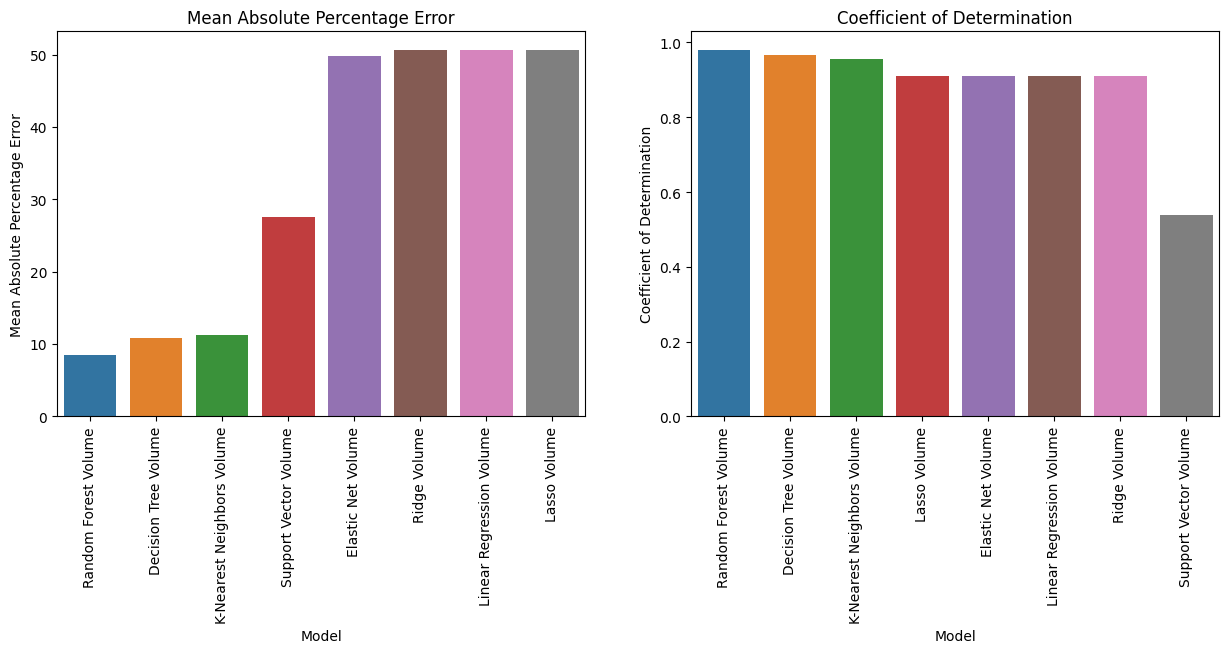

In [120]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
barplot_result = sns.barplot(x="Model", y="Mean Absolute Percentage Error", data=results_volume, order=results_volume.sort_values('Mean Absolute Percentage Error').Model, ax=axes[0])
barplot_result.set_xticklabels(barplot_result.get_xticklabels(), rotation=90,)
axes[0].set_title("Mean Absolute Percentage Error")
barplot_result = sns.barplot(x="Model", y="Coefficient of Determination", data=results_volume, order=results_volume.sort_values('Coefficient of Determination', ascending=False).Model, ax=axes[1])
barplot_result.set_xticklabels(barplot_result.get_xticklabels(), rotation=90,)
axes[1].set_title("Coefficient of Determination")
plt.show()

- Random Forest seems like the best algorithm again.
- This time Support Vector Machine performed much better compared to the original data, and the worst algorithm is not too certain for now.

### Density Data Results

In [121]:
results_density = pd.DataFrame(columns=["Model", 
                                "Mean Squared Error",
                                "Root Mean Squared Error",
                                "Mean Absolute Error",
                                "Mean Absolute Percentage Error",
                                "Coefficient of Determination",
                                "Adjusted Coefficient of Determination",
                                "Explained Variance Score"],
                                index=None)

In [122]:
# Independent variables
X = gem_data_density.drop("price", axis=1)

# Dependent variable
y = gem_data_density["price"]

X_train_density, X_test_density, y_train_density, y_test_density = train_test_split(X, y, test_size=0.3, random_state=42)

In [123]:
lr_preds_density = regression("Linear Regression Density", linear_model, X_train_density, X_test_density, y_train_density, y_test_density, results_density)
knn_preds_density = regression("K-Nearest Neighbors Density", knn_model, X_train_density, X_test_density, y_train_density, y_test_density, results_density)
decision_tree_preds_density = regression("Decision Tree Density", decision_tree_model, X_train_density, X_test_density, y_train_density, y_test_density, results_density)
random_forest_preds_density = regression("Random Forest Density", random_forest_model, X_train_density, X_test_density, y_train_density, y_test_density, results_density)
svm_preds_density = regression("Support Vector Density", svr_model, X_train_density, X_test_density, y_train_density, y_test_density, results_density)
lasso_preds_density = regression("Lasso Density", lasso_model, X_train_density, X_test_density, y_train_density, y_test_density, results_density)
ridge_preds_density = regression("Ridge Density", ridge_model, X_train_density, X_test_density, y_train_density, y_test_density, results_density)
elastic_net_preds_density = regression("Elastic Net Density", elastic_net_model, X_train_density, X_test_density, y_train_density, y_test_density, results_density)

In [124]:
results_density

,Model,Mean Squared Error,Root Mean Squared Error,Mean Absolute Error,Mean Absolute Percentage Error,Coefficient of Determination,Adjusted Coefficient of Determination,Explained Variance Score
0,Linear Regression Density,1.529370e+07,3910.715794,2872.734488,174.104420,0.064682,0.063987,0.064788
1,K-Nearest Neighbors Density,1.701844e+07,4125.340817,2957.588475,165.825703,-0.040798,-0.041571,-0.040758
2,Decision Tree Density,2.699194e+07,5195.377110,3357.127715,163.921026,-0.650749,-0.651974,-0.650228
3,Random Forest Density,1.410252e+07,3755.332646,2688.486351,152.554350,0.137531,0.136890,0.139379
4,Support Vector Density,1.866954e+07,4320.826357,2818.936001,110.559307,-0.141775,-0.142623,0.001352
5,Lasso Density,1.524548e+07,3904.546128,2898.787852,177.806486,0.067631,0.066938,0.067695
6,Ridge Density,1.524531e+07,3904.524346,2898.762610,177.803713,0.067641,0.066949,0.067706
7,Elastic Net Density,1.524774e+07,3904.835087,2900.049479,177.983261,0.067493,0.066800,0.067557


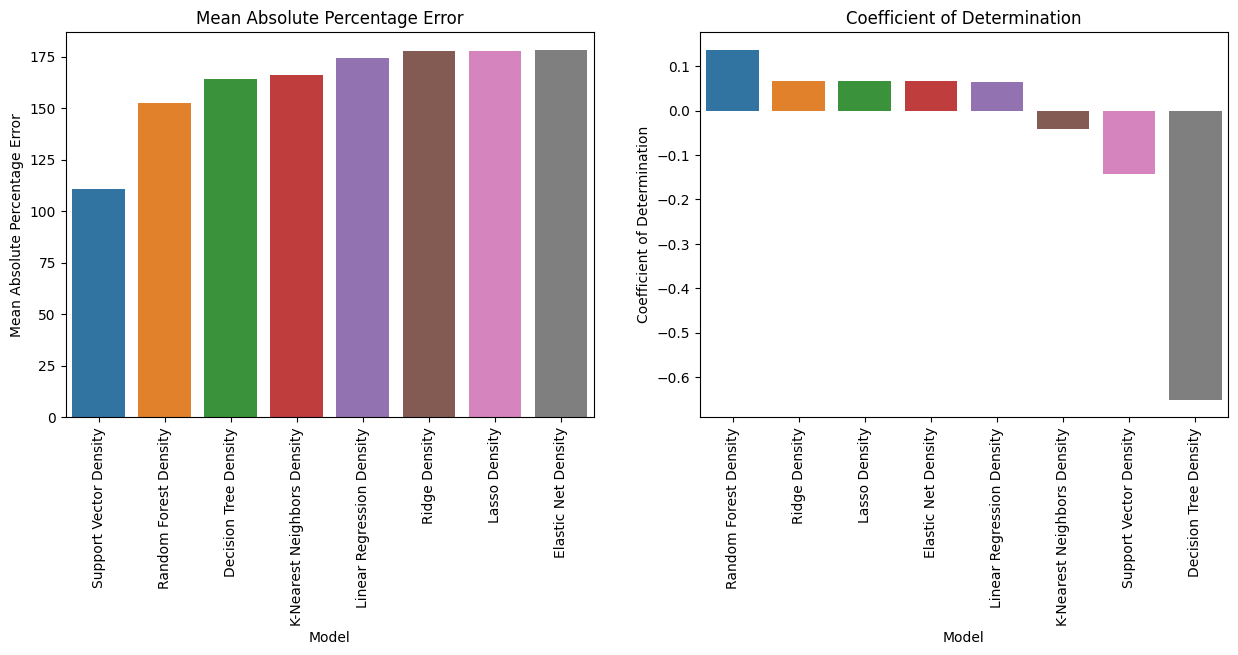

In [125]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
barplot_result = sns.barplot(x="Model", y="Mean Absolute Percentage Error", data=results_density, order=results_density.sort_values('Mean Absolute Percentage Error').Model, ax=axes[0])
barplot_result.set_xticklabels(barplot_result.get_xticklabels(), rotation=90,)
axes[0].set_title("Mean Absolute Percentage Error")
barplot_result = sns.barplot(x="Model", y="Coefficient of Determination", data=results_density, order=results_density.sort_values('Coefficient of Determination', ascending=False).Model, ax=axes[1])
barplot_result.set_xticklabels(barplot_result.get_xticklabels(), rotation=90,)
axes[1].set_title("Coefficient of Determination")
plt.show()

By looking at these results, we can conclude that engineering the column "density" and removing "carat" + "volume" was not a good choice. All of the metrics are bad and any of the algorithms couldn't perform good in general.

# Conclusion

## Comparing Based on Metrics

Since original data and volume data predictions have good metrics, we will be comparing them and choose the better approach. Since density was a failure, it won't be included in this comparison.

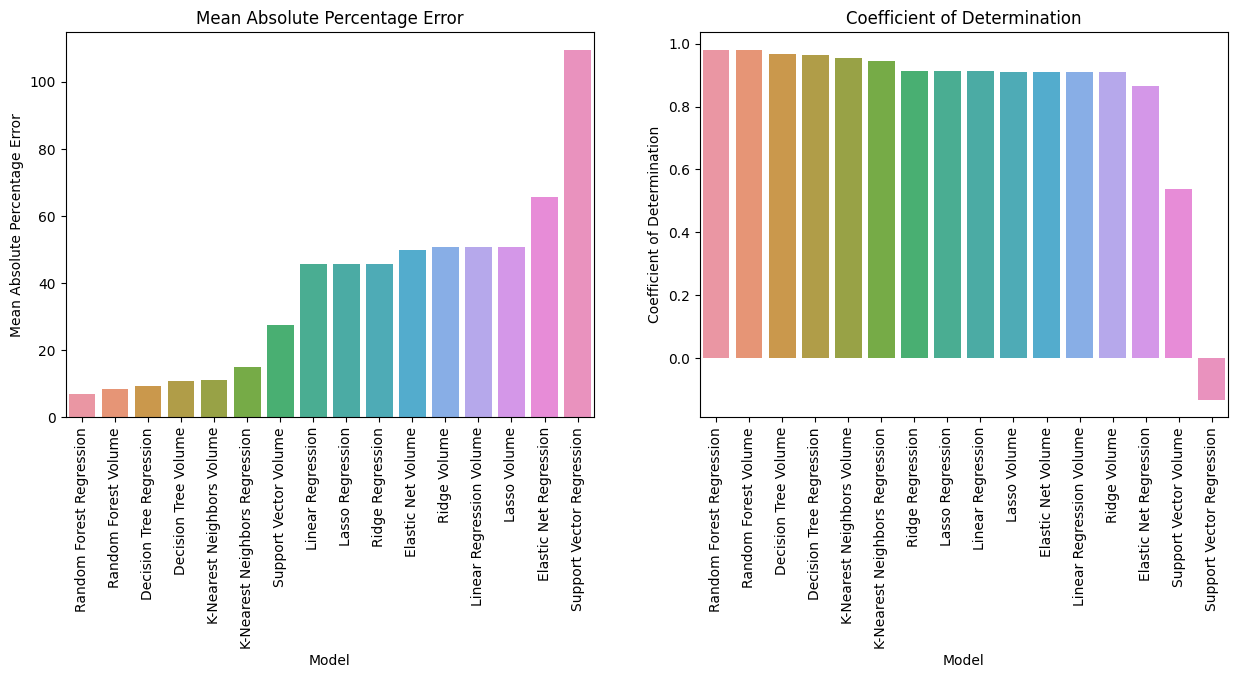

In [126]:
results_merged = pd.concat([results, results_volume], axis=0)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
barplot_result = sns.barplot(x="Model", y="Mean Absolute Percentage Error", data=results_merged, order=results_merged.sort_values('Mean Absolute Percentage Error').Model, ax=axes[0])
barplot_result.set_xticklabels(barplot_result.get_xticklabels(), rotation=90,)
axes[0].set_title("Mean Absolute Percentage Error")
barplot_result = sns.barplot(x="Model", y="Coefficient of Determination", data=results_merged, order=results_merged.sort_values('Coefficient of Determination', ascending=False).Model, ax=axes[1])
barplot_result.set_xticklabels(barplot_result.get_xticklabels(), rotation=90,)
axes[1].set_title("Coefficient of Determination")
plt.show()

When algorithm results are compared, performance order is as follows:
1. Random Forest (Original Data)
2. Random Forest (Volume Data)
3. Decision Tree (Original Data, since Coefficient of Determination values are too close, but Mean Absolute Percentage Error values are more different)
4. Decision Tree (Volume Data)
5. K-Nearest Neighbors (Volume Data)
6. K-Nearest Neighbors (Original Data)

...

12. SVM (Original Data)

In [127]:
best_models = pd.DataFrame(columns=["Model",
                                    "Mean Absolute Percentage Error",
                                    "Coefficient of Determination"],
                                    index=None)

best_models = pd.concat([best_models, results[results["Model"] == "Random Forest Regression"]], axis=0)
best_models = pd.concat([best_models, results_volume[results_volume["Model"] == "Random Forest Volume"]], axis=0)
best_models = pd.concat([best_models, results[results["Model"] == "Decision Tree Regression"]], axis=0)
best_models = pd.concat([best_models, results_volume[results_volume["Model"] == "Decision Tree Volume"]], axis=0)
best_models = pd.concat([best_models, results_volume[results_volume["Model"] == "K-Nearest Neighbors Volume"]], axis=0)
best_models = pd.concat([best_models, results[results["Model"] == "K-Nearest Neighbors Regression"]], axis=0)
best_models = best_models.reset_index(drop=True)

best_models

,Model,Mean Absolute Percentage Error,Coefficient of Determination,Mean Squared Error,Root Mean Squared Error,Mean Absolute Error,Adjusted Coefficient of Determination,Explained Variance Score
0,Random Forest Regression,6.986513,0.981187,307619.241385,554.634331,281.682789,0.981166,0.981187
1,Random Forest Volume,8.446108,0.980777,314324.477542,560.646482,291.758448,0.980760,0.980777
2,Decision Tree Regression,9.364087,0.963434,597906.769414,773.244314,387.644924,0.963393,0.963434
3,Decision Tree Volume,10.761470,0.966078,554664.426882,744.757965,385.281625,0.966049,0.966078
4,K-Nearest Neighbors Volume,11.181273,0.955313,730693.169299,854.805925,427.659627,0.955274,0.955369
5,K-Nearest Neighbors Regression,14.954707,0.945554,890262.849749,943.537413,513.421640,0.945493,0.945707


We can say that Random Forest on original data is the best performing approach for predicting the "price" values among other machine learning algorithms since:
- It has lower MAPE value **(6.97)**, which means the percentage of the errors is much smaller than others,
- It has higher Coefficient of Determination (R-squared) Score **(0.98)**, which means model explains a higher ratio of variability.

## Comparing Based on Predicted Values vs. Actual Values Visualization

We created a dataframe with the actual and predicted price values for the best models (and the worst model) according to the metrics calculated above.

In [128]:
actual_vs_predicted = pd.DataFrame({"Actual": y_test, "RF_Predicted": rf_preds, "RF_Volume_Predicted": random_forest_preds_volume, "DT_Predicted": dt_preds, "DT_Volume_Predicted": decision_tree_preds_volume, "KNN_Volume_Predicted": knn_preds_volume, "KNN_Predicted": knn_preds, "SVR_Predicted": svr_preds})

Now, we will plot the actual values vs predicted values for each model and make our final decisions

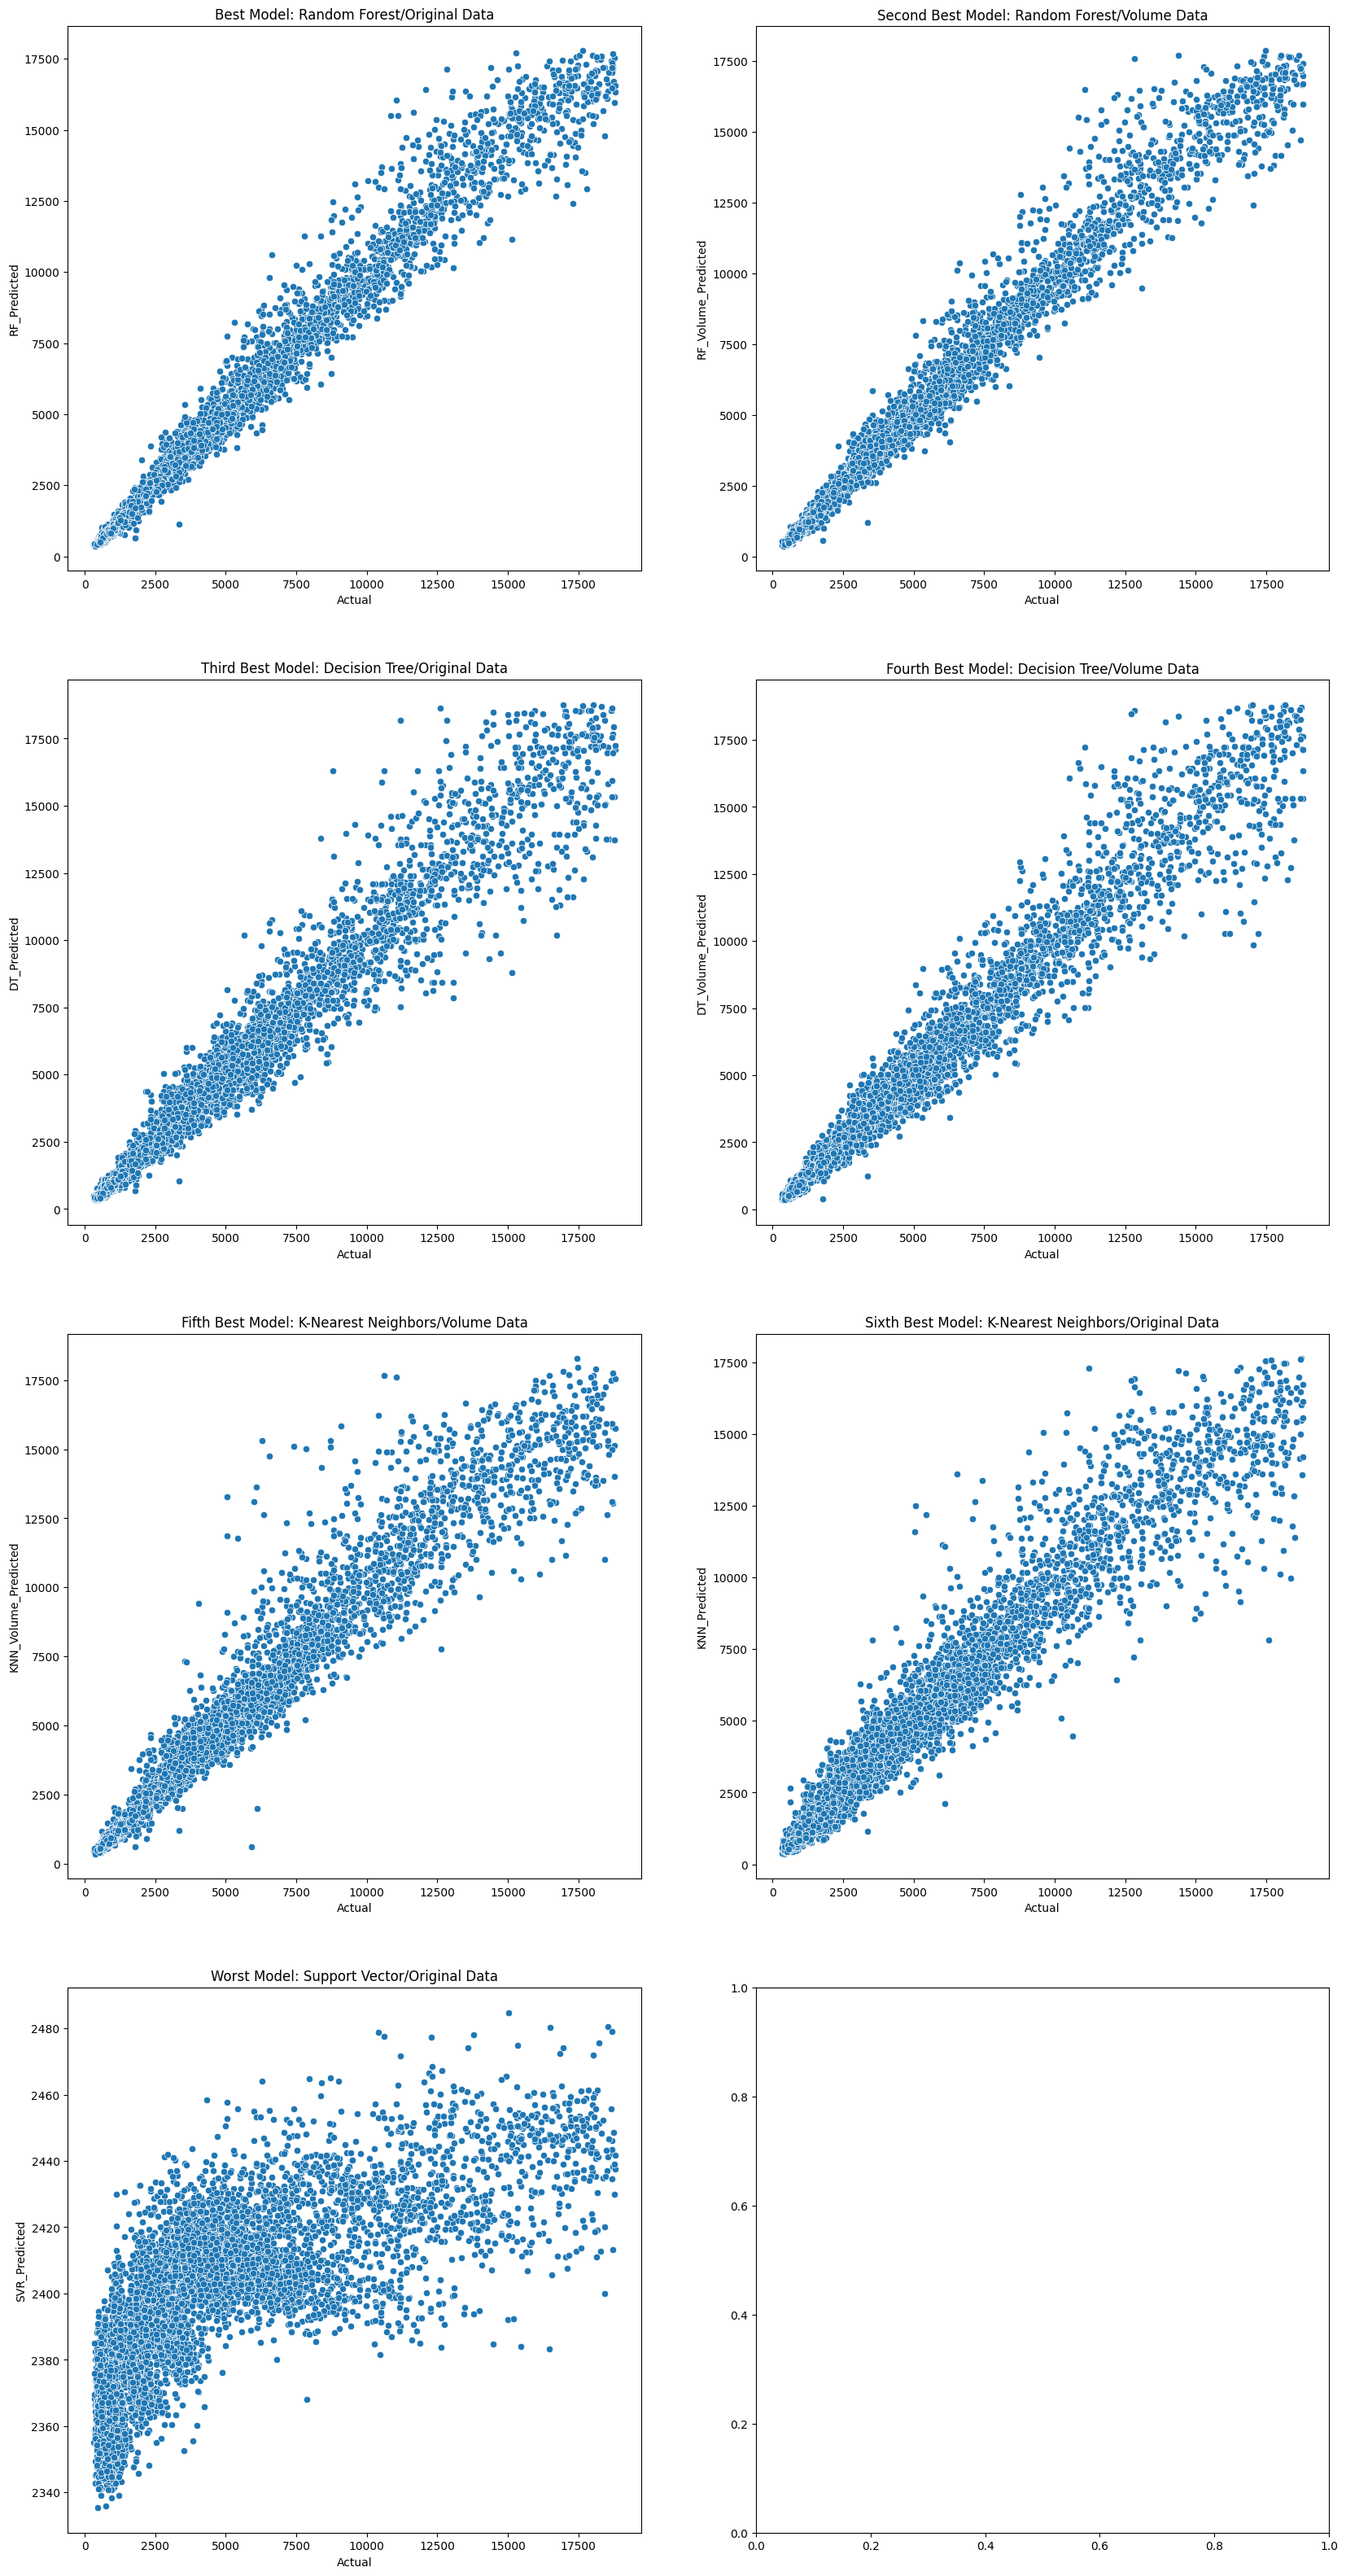

In [129]:
fig, axes = plt.subplots(4, 2, figsize=(20, 40))
sns.scatterplot(x="Actual", y="RF_Predicted", data=actual_vs_predicted, ax=axes[0, 0]).set_title("Best Model: Random Forest/Original Data")
sns.scatterplot(x="Actual", y="RF_Volume_Predicted", data=actual_vs_predicted, ax=axes[0, 1]).set_title("Second Best Model: Random Forest/Volume Data")
sns.scatterplot(x="Actual", y="DT_Predicted", data=actual_vs_predicted, ax=axes[1, 0]).set_title("Third Best Model: Decision Tree/Original Data")
sns.scatterplot(x="Actual", y="DT_Volume_Predicted", data=actual_vs_predicted, ax=axes[1, 1]).set_title("Fourth Best Model: Decision Tree/Volume Data")
sns.scatterplot(x="Actual", y="KNN_Volume_Predicted", data=actual_vs_predicted, ax=axes[2, 0]).set_title("Fifth Best Model: K-Nearest Neighbors/Volume Data")
sns.scatterplot(x="Actual", y="KNN_Predicted", data=actual_vs_predicted, ax=axes[2, 1]).set_title("Sixth Best Model: K-Nearest Neighbors/Original Data")
sns.scatterplot(x="Actual", y="SVR_Predicted", data=actual_vs_predicted, ax=axes[3, 0]).set_title("Worst Model: Support Vector/Original Data")
plt.show()

It's easy to say that the Random Forest plot has the best straight diagonal line and less scatter, which means the predictions are quite closer to real values compared to other algorithms. 

Overall, we conclude that for the prediction of cubic zirconia prices:
- ***Random Forest*** is the **best** algorithm (and **sufficient** enough),
- Engineering new columns affected the best algorithms poorly, but improved the worst algorithms. 
- ***SVM*** is the **worst** algorithm (on original data),
- Regression is successful and discretization+classification approach is not necessary.

